# Zonal average

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import numpy as np

In [2]:
data_file = '/pool/data/MESSY/DATA/MESSy2/raw/offemis/CMIP6/CMIP6v1.1_DLR1.0_ssp370_road_MISC_201501-201512.nc'

data = xr.open_dataset(data_file).drop('lev')

CO_flux = data['CO_flux']
NH3_flux = data['NH3_flux']
NOx_flux = data['NOx_flux']
SO2_flux = data['SO2_flux']

CO_flux_average = CO_flux.mean(dim='time')

If we compare two different projections of the average CO flux we notice an actual difference in plotted intensity. This is because a grid in degrees does not deal with the fact that the area of the quadrant changes with every latitude. Let's see it in practice

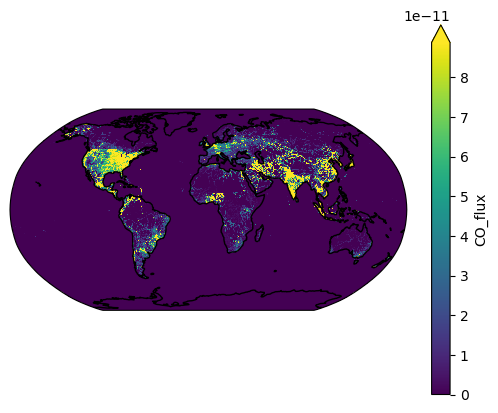

In [3]:
ax = plt.axes(projection=ccrs.Robinson())
CO_flux_average.plot(robust= True, ax=ax, transform=ccrs.PlateCarree()) 
ax.coastlines();

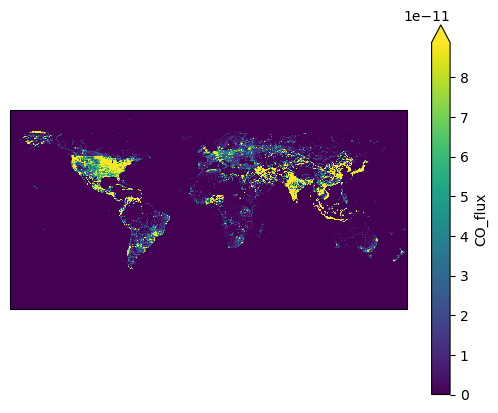

In [4]:
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines();
CO_flux_average.plot(robust= True);

If we look at Alaska, New Zealand, Greenland, and the south most points of Africa and South America we can clearly see a difference in the value of the flux between plots. This also means that if we average  blindly over longitude and latitude we get wrong values

In [5]:
wrong_CO = CO_flux.mean()     # this is wrong
wrong_NH3 = NH3_flux.mean()   # this is wrong
wrong_SO2 = SO2_flux.mean()   # this is wrong
wrong_NOx = NOx_flux.mean()   # this is wrong

If instead we take the weight of the latitude into consideration (converting to randiants for convenience), we get

In [6]:
weight = np.cos(np.deg2rad(data.lat)) #deg2rad converts the latitude from degrees to radians
weights = weight / weight.sum() #weigh each latitudinal band by dividing it by the summed weights

zonal_CO_average = CO_flux_average.mean(dim='lon')  # important! Always average over longitudes first
weighted_CO_avg = np.sum(zonal_CO_average * weights) #sum over all weighted latitudinal t2m values

Which we can see is different than the naive average above

One important quantity used to compare different emissions datasets is the averaged emission per month

In [7]:
zonal_NH3_flux = NH3_flux.mean(dim='lon')
weighted_NH3 = zonal_NH3_flux * weights
monthly_average_NH3 = weighted_NH3.mean('lat')
monthly_average_NH3

<xarray.DataArray (time: 12, lev: 1)>
array([[6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17],
       [6.65009598e-17]])
Coordinates:
  * time     (time) object 2015-01-16 00:00:00 ... 2015-12-16 00:00:00
Dimensions without coordinates: lev

When we plot it, we notice the emissions are constant throughout the year. This is likely an assumption linked to this inventory (road traffic is constant during the year)

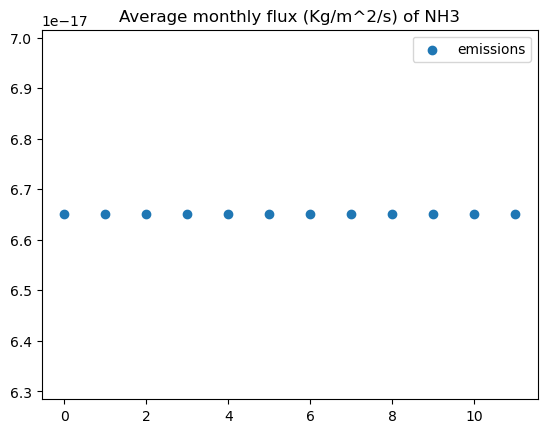

In [8]:
x = range(12)
y = monthly_average_NH3
plt.title("Average monthly flux (Kg/m^2/s) of NH3")
plt.scatter(x, y, marker = "o", label = 'emissions')
plt.legend()
plt.show()

For this reason, it's pretty obvious what the time average is going to be, but for future reference:

In [9]:
monthly_average_NH3.mean('time')

<xarray.DataArray (lev: 1)>
array([6.65009598e-17])
Dimensions without coordinates: lev

In [10]:
def monthly_weighted_average(emission):
    weight_emission = np.cos(np.deg2rad(emission.lat)) #deg2rad converts the latitude from degrees to radians
    weight_emission = weight_emission / weight_emission.sum() #weigh each latitudinal band by dividing it by the summed weights

    emission_avg = emission.mean('time')
    emission_avg_lon = emission_avg.mean(dim='lon')  # important! Always average over longitudes first
    emission_zonal_avg = np.sum(emission_avg_lon * weight_emission) #sum over all weighted latitudinal t2m values
    return emission_zonal_avg

and plot the values for all yearly eaverage emission fluxes

In [11]:
NH3_monthly_weighted_average = monthly_weighted_average(NH3_flux)
CO_monthly_weighted_average = monthly_weighted_average(CO_flux)
SO2_monthly_weighted_average = monthly_weighted_average(SO2_flux)
NOx_monthly_weighted_average = monthly_weighted_average(NOx_flux)
NH3_monthly_weighted_average

<xarray.DataArray ()>
array(2.39403455e-14)

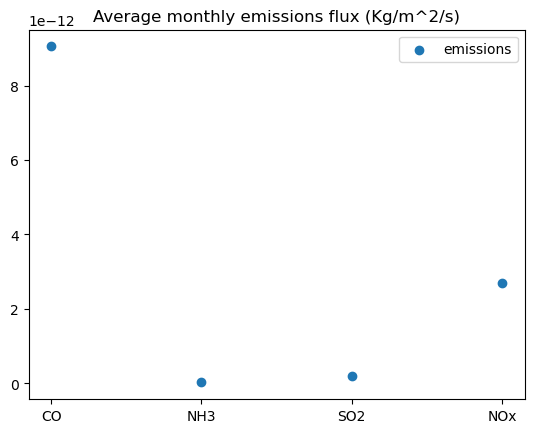

In [12]:
x = ('CO', 'NH3', 'SO2', 'NOx')
y = np.array([CO_monthly_weighted_average, NH3_monthly_weighted_average, SO2_monthly_weighted_average, NOx_monthly_weighted_average])
plt.title("Average monthly emissions flux (Kg/m^2/s)")
plt.scatter(x, y, marker = "o", label = 'emissions')
plt.legend()
plt.show()

In [13]:
print("NOx average monthly flux: ", NOx_monthly_weighted_average.data)
print("NH3 average monthly flux: ", NH3_monthly_weighted_average.data)
print("CO average monthly flux: ", CO_monthly_weighted_average.data)
print("SO2 average monthly flux: ", SO2_monthly_weighted_average.data)

NOx average monthly flux:  2.6888467568258305e-12
NH3 average monthly flux:  2.3940345483130416e-14
CO average monthly flux:  9.050780760297381e-12
SO2 average monthly flux:  1.9979353814823411e-13


If we want to go from flux to emission, we need to integrate over the areas of the grid

Since we have a yearly weighted average flux, integrating over the area just means multiplying our values by the area of the whole sphere, aka the earth, and over a year, aka yearly seconds

In [14]:
area_earth = 5.1006447295*pow(10,14)
seconds_in_year = 31536000

In [15]:
NOx_yearly_weighted_average = NOx_monthly_weighted_average.data *  area_earth * pow(10, -9) * seconds_in_year
NH3_yearly_weighted_average = NH3_monthly_weighted_average.data * area_earth * pow(10, -9) * seconds_in_year
CO_yearly_weighted_average = CO_monthly_weighted_average.data * area_earth * pow(10, -9) * seconds_in_year
SO2_yearly_weighted_average = SO2_monthly_weighted_average.data * area_earth * pow(10, -9) * seconds_in_year

In [16]:
# In tg
print("NOx yearly emissions (Tg): ", NOx_yearly_weighted_average)
print("NH3 yearly emissions (Tg): ", NH3_yearly_weighted_average)
print("CO yearly emissions (Tg): ", CO_yearly_weighted_average)
print("SO2 yearly emissions (Tg): ", SO2_yearly_weighted_average)

NOx yearly emissions (Tg):  43.25115738904515
NH3 yearly emissions (Tg):  0.385089870893695
CO yearly emissions (Tg):  145.58536746790148
SO2 yearly emissions (Tg):  3.2137576237198733


In [17]:
# Silly experiment 
print("silly NOx yearly emissions (Tg): ", NOx_flux.mean().data *  area_earth * pow(10, -9) * seconds_in_year )
print("silly NH3 yearly emissions (Tg): ", NH3_flux.mean().data *  area_earth * pow(10, -9) * seconds_in_year)
print("silly CO yearly emissions (Tg): ", CO_flux.mean().data *  area_earth * pow(10, -9) * seconds_in_year)
print("silly SO2 yearly emissions (Tg): ", SO2_flux.mean().data *  area_earth * pow(10, -9) * seconds_in_year)

silly NOx yearly emissions (Tg):  33.909040900360395
silly NH3 yearly emissions (Tg):  0.3200491685175039
silly CO yearly emissions (Tg):  111.3546697399305
silly SO2 yearly emissions (Tg):  2.469293405421405
